[RuCode] Fake Jobs classification <br>
https://www.kaggle.com/c/rucode-fake-job-postings/overview/evaluation <br>
score = 0.745 (f1_score)

In [ ]:
import keras
import nltk
import pandas as pd
import numpy as np
import re
import codecs

In [ ]:
!pip install transformers
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import matplotlib.pyplot as plt
import gensim
from string import punctuation
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, Flatten, Dropout,Concatenate, Add
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import LSTM, Bidirectional
from keras.models import Model

tqdm.pandas()
nltk.download('stopwords')
stop_words = stopwords.words('english')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH = '/content/drive/My Drive/FakeJobs/'

df = pd.read_csv(PATH + 'train_data.csv')
df_test = pd.read_csv(PATH + 'test_data.csv')
df.head(1)

,Id,Название,Место,Отдел,Зарплата,Описание компании,Описание вакансии,Требования,Соцпакет,Дистанционно,Вопросы,Тип занятости,Опыт,Образование,Индустрия,Позиция,Фейк
0,10497,"Reporter, Agri Investor","US, ,",KHR,NaN,PEI Media (#URL_4cffe430b8da4c0d7e6074d11e638d...,Seeking savvy business reporter Are you a news...,The successful candidate should have a bachelo...,PEI Media (#URL_4cffe430b8da4c0d7e6074d11e638d...,0,0,Full-time,Associate,Bachelor's Degree,Publishing,Writing/Editing,0


 # Preprocessing

In [ ]:
text_features = ['Название', 'Место', 'Отдел', 'Описание компании', 'Описание вакансии', 'Требования', 'Соцпакет']
cat_features = ['Дистанционно', 'Вопросы', 'Тип занятости', 'Опыт', 'Образование', 'Индустрия', 'Позиция']
#non_text_features = ['Зарплата','Дистанционно', 'Вопросы', 'Тип занятости', 'Опыт', 'Образование', 'Индустрия', 'Позиция']
text_df = df[text_features]
text_df_test = df_test[text_features]
cat_df = df[cat_features]
cat_df_test = df_test[cat_features]
text_df = text_df.fillna(' ')
cat_df = cat_df.fillna("None")
text_df_test = text_df_test.fillna(' ')
cat_df_test = cat_df_test.fillna("None")
cat_df.head(1)

,Дистанционно,Вопросы,Тип занятости,Опыт,Образование,Индустрия,Позиция
0,0,0,Full-time,Associate,Bachelor's Degree,Publishing,Writing/Editing


In [ ]:
text = text_df[text_df.columns[0:-1]].apply(lambda x: ','.join(x.dropna().astype(str)),axis=1)
target = df['Фейк']
text_test = text_df_test[text_df_test.columns[0:-1]].apply(lambda x: ','.join(x.dropna().astype(str)),axis=1)
print(len(text))
print(len(text_test))

10728
7152


In [ ]:

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\\xa0', ' ', text)
    text = re.sub('\(#url*\)', ' ', text)
    text = re.sub('\[.*?\]', ' ', text)
    text = re.sub('https?://\S+|www\.\S+', ' ', text)
    text = re.sub('[^A-Za-z0-9(),!?@\'\`\"\_\n]', ' ',text)
    text = re.sub('[%s]' % re.escape(punctuation), ' ', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\w*\d\w*', ' ', text)
    return text


# Applying the cleaning function to both test and training datasets
text = text.apply(lambda x: clean_text(x))
text_test = text_test.apply(lambda x: clean_text(x))
text[0]

'reporter  agri investor us     khr pei media   url     provides a range of highly respected publications and market leading events to its financial sector audience  the leading information provider in private capital markets  pei media also has a strong international presence  with offices in london  new york and hong kong  seeking savvy business reporter are you a news hungry journalist  have a passion for finance  a talent for breaking news  networking and developing sophisticated sources if so  there s an exciting full time reporter position available with pei media  the leading global   financial publishing and information group focused exclusively on alternative asset classes based in manhattan  this opening is a rare opportunity for an ambitious individual seeking to advance their career in one of the most dynamic segments of global finance the position is tied to agri investor   url      a growing online news and intelligence platform covering private markets investment in agri

In [ ]:

tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

# appling tokenizer5
tokens = text.progress_apply(lambda x: tokenizer.tokenize(x))
tokens_test = text_test.progress_apply(lambda x: tokenizer.tokenize(x))
len(tokens[0])

['reporter',
 'agri',
 'investor',
 'us',
 'khr',
 'pei',
 'media',
 'url',
 'provides',
 'a',
 'range',
 'of',
 'highly',
 'respected',
 'publications',
 'and',
 'market',
 'leading',
 'events',
 'to',
 'its',
 'financial',
 'sector',
 'audience',
 'the',
 'leading',
 'information',
 'provider',
 'in',
 'private',
 'capital',
 'markets',
 'pei',
 'media',
 'also',
 'has',
 'a',
 'strong',
 'international',
 'presence',
 'with',
 'offices',
 'in',
 'london',
 'new',
 'york',
 'and',
 'hong',
 'kong',
 'seeking',
 'savvy',
 'business',
 'reporter',
 'are',
 'you',
 'a',
 'news',
 'hungry',
 'journalist',
 'have',
 'a',
 'passion',
 'for',
 'finance',
 'a',
 'talent',
 'for',
 'breaking',
 'news',
 'networking',
 'and',
 'developing',
 'sophisticated',
 'sources',
 'if',
 'so',
 'there',
 's',
 'an',
 'exciting',
 'full',
 'time',
 'reporter',
 'position',
 'available',
 'with',
 'pei',
 'media',
 'the',
 'leading',
 'global',
 'financial',
 'publishing',
 'and',
 'information',
 'group'

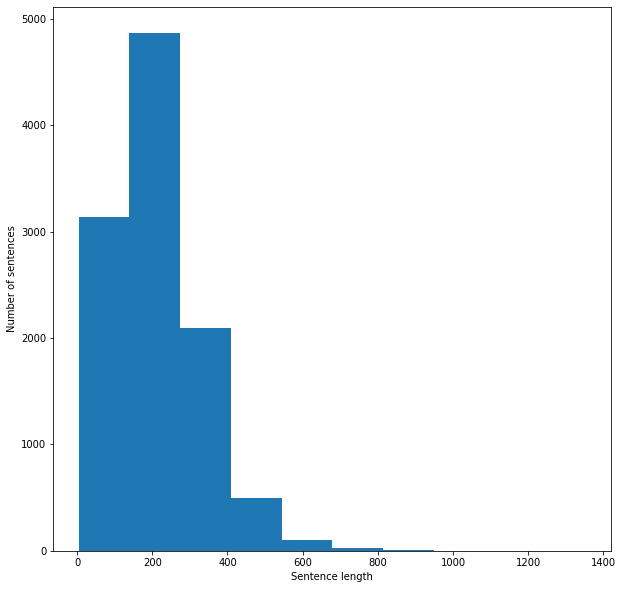

In [ ]:


fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

In [ ]:

def remove_stopwords(text):
    """
    Removing stopwords belonging to english language
    
    """
    words = [w for w in text if (w not in stop_words) and (len(w) > 3)]
    return words


tokens = tokens.progress_apply(lambda x : remove_stopwords(x))
tokens_test = tokens_test.progress_apply(lambda x : remove_stopwords(x))
len(tokens[0])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


152

In [ ]:
all_words = [word for sent in tokens for word in sent]
sentence_lengths = [len(sent) for sent in tokens]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

2262758 words total, with a vocabulary size of 64605
Max sentence length is 1354


In [ ]:
def combine_text(list_of_text):
    combined_text = ' '.join(list_of_text)
    return combined_text

clean_text = tokens.apply(lambda x : combine_text(x))
clean_text_test = tokens_test.apply(lambda x : combine_text(x))
clean_text[0]

'reporter agri investor media provides range highly respected publications market leading events financial sector audience leading information provider private capital markets media also strong international presence offices london york hong kong seeking savvy business reporter news hungry journalist passion finance talent breaking news networking developing sophisticated sources exciting full time reporter position available media leading global financial publishing information group focused exclusively alternative asset classes based manhattan opening rare opportunity ambitious individual seeking advance career dynamic segments global finance position tied agri investor growing online news intelligence platform covering private markets investment agriculture agribusiness successful candidate bachelor degree equivalent least three years journalism related writing reporting experience demonstrable passion business finance investment essential ability work independently part global team

# CountVectorizer/TfidfVectorizer + LogReg

In [ ]:

def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_corpus = clean_text.tolist()
list_labels = target

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.986, precision = 0.985, recall = 0.986, f1 = 0.985


In [ ]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 10)

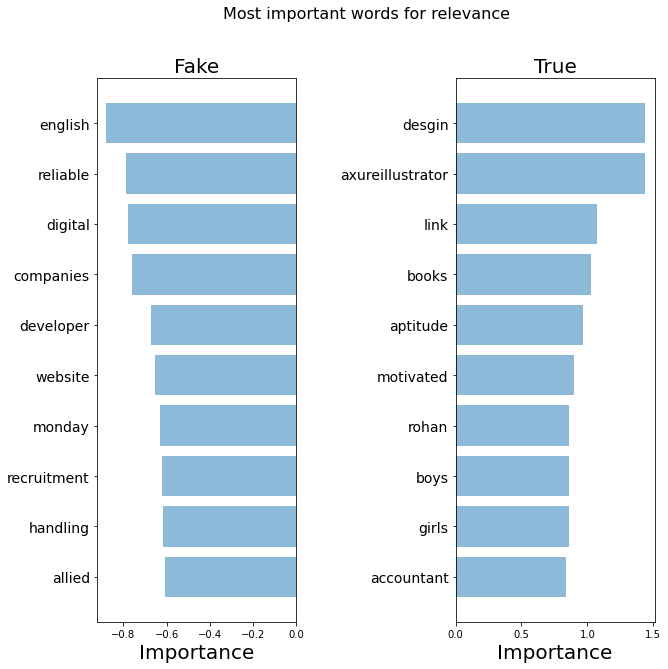

In [ ]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Fake', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('True', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

In [ ]:
clf_w2v = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', random_state=40)
clf_w2v.fit(X_train_word2vec, y_train_word2vec)
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

In [ ]:
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_test_word2vec, y_predicted_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec, 
                                                                       recall_word2vec, f1_word2vec))

accuracy = 0.900, precision = 0.955, recall = 0.900, f1 = 0.920


# BERT + NeuralNetwork

In [ ]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [ ]:
size = 1000
batches = [batch_1[i:i+size] for i in range(0, batch_1.shape[0] ,size)]
batches_test = [batch_2[i:i+size] for i in range(0, batch_2.shape[0] ,size)]

In [ ]:
features = []
for batch_1 in tqdm(batches):
  tokenized_test = batch_1.apply((lambda x: tokenizer.encode(x, max_length = 60, add_special_tokens=True, truncation=True)))
  max_len = 0
  for i in tokenized_test.values:
    if len(i) > max_len:
        max_len = len(i)
  padded_test = np.array([i + [0]*(max_len-len(i)) for i in tokenized_test.values])
  attention_mask_test = np.where(padded_test != 0, 1, 0)
  input_ids_test = torch.tensor(padded_test)
  attention_mask = torch.tensor(attention_mask_test) 
  with torch.no_grad():
    last_hidden_states_test = model(input_ids_test, attention_mask=attention_mask)
  if len(features)>0:
    features = np.concatenate((last_hidden_states_test[0][:,0,:].numpy(), features),axis=0)
  else:
    features = last_hidden_states_test[0][:,0,:].numpy()
features.shape

(10728, 768)

In [ ]:
features_test = []
for batch_1 in tqdm(batches_test):
  tokenized_test = batch_1.apply((lambda x: tokenizer.encode(x, max_length = 60, add_special_tokens=True, truncation=True)))
  max_len = 0
  for i in tokenized_test.values:
    if len(i) > max_len:
        max_len = len(i)
  padded_test = np.array([i + [0]*(max_len-len(i)) for i in tokenized_test.values])
  attention_mask_test = np.where(padded_test != 0, 1, 0)
  input_ids_test = torch.tensor(padded_test)
  attention_mask = torch.tensor(attention_mask_test) 
  with torch.no_grad():
    last_hidden_states_test = model(input_ids_test, attention_mask=attention_mask)
  if len(features_test)>0:
    features_test = np.concatenate((last_hidden_states_test[0][:,0,:].numpy(), features_test),axis=0)
  else:
    features_test = last_hidden_states_test[0][:,0,:].numpy()
features_test.shape

(7152, 768)

In [ ]:
features = last_hidden_states[0][:,0,:].numpy()
labels = target_1

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

In [ ]:
target

0        0
1        0
2        0
3        0
4        0
        ..
10723    0
10724    0
10725    0
10726    0
10727    0
Name: Фейк, Length: 10728, dtype: int64

In [ ]:
# train default para
model = Sequential()

model.add(Dense(200, input_dim=768, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(1))
model.add(Activation('sigmoid'))

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1])

In [ ]:

model.fit(features, target_1)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

# Word2Vec + Convolutional Neural Network (Yoon Kim)

In [ ]:

word2vec_path = PATH + "GoogleNews-vectors-negative300.bin.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

INFO - 11:31:50: loading projection weights from /content/drive/My Drive/FakeJobs/GoogleNews-vectors-negative300.bin.gz
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
INFO - 11:33:52: loaded (3000000, 300) matrix from /content/drive/My Drive/FakeJobs/GoogleNews-vectors-negative300.bin.gz


In [ ]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = clean_questions['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [ ]:

clean_questions = pd.DataFrame(df['text'])
clean_questions['class_label'] = df['Фейк']
clean_questions["tokens"] = clean_questions["text"].apply(tokenizer.tokenize)
clean_questions_test = pd.DataFrame(df_test['text'])
clean_questions_test["tokens"] = clean_questions_test["text"].apply(tokenizer.tokenize)
clean_questions.head(2)

,text,class_label,tokens
0,reporter agri investor us khr pei media url pr...,0,"[reporter, agri, investor, us, khr, pei, media..."
1,software engineer us va herndon software engin...,0,"[software, engineer, us, va, herndon, software..."


In [ ]:

all_words = [word for tokens in clean_questions["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in clean_questions["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

2458294 words total, with a vocabulary size of 69495
Max sentence length is 1422


In [ ]:
list_labels = target.to_list()

In [ ]:
embeddings = get_word2vec_embeddings(word2vec, clean_questions)
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, list_labels, 
                                                                                        test_size=0.2, random_state=40)

In [ ]:

EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 1422
VOCAB_SIZE = len(VOCAB)

VALIDATION_SPLIT=.2
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(clean_questions["text"].tolist())
sequences = tokenizer.texts_to_sequences(clean_questions["text"].tolist())

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

cnn_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = np.asarray(clean_questions["class_label"])#to_categorical(np.asarray(clean_questions["class_label"]))

indices = np.arange(cnn_data.shape[0])
np.random.shuffle(indices)
cnn_data = cnn_data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * cnn_data.shape[0])

embedding_weights = np.zeros((len(word_index)+1, EMBEDDING_DIM))
for word,index in word_index.items():
    embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(embedding_weights.shape)

Found 69495 unique tokens.
(69496, 300)


In [ ]:

def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index, trainable=False, extra_conv=True):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=trainable)

    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    # Yoon Kim model (https://arxiv.org/abs/1408.5882)
    convs = []
    filter_sizes = [3,4,5]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=128, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(pool_size=3)(l_conv)
        convs.append(l_pool)

    l_merge = Concatenate(axis=1)(convs)

    # add a 1D convnet with global maxpooling, instead of Yoon Kim model
    conv = Conv1D(filters=128, kernel_size=3, activation='relu')(embedded_sequences)
    pool = MaxPooling1D(pool_size=3)(conv)

    if extra_conv==True:
        x = Dropout(0.5)(l_merge)  
    else:
        # Original Yoon Kim model
        x = Dropout(0.5)(pool)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    #x = Dropout(0.5)(x)

    preds = Dense(labels_index, activation='softmax')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

    return model

In [ ]:
x_train = cnn_data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = cnn_data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

model = ConvNet(embedding_weights, MAX_SEQUENCE_LENGTH, len(word_index)+1, EMBEDDING_DIM, 
                len(list(clean_questions["class_label"].unique())), False)

In [ ]:
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=3, batch_size=128)

Epoch 1/3
68/68 [==============================] - 575s 8s/step - loss: 1.1910 - acc: 0.1427 - val_loss: 0.6932 - val_acc: 0.0476
Epoch 2/3
68/68 [==============================] - 573s 8s/step - loss: 0.6932 - acc: 0.0491 - val_loss: 0.6931 - val_acc: 0.0476
Epoch 3/3
68/68 [==============================] - 574s 8s/step - loss: 0.6931 - acc: 0.0491 - val_loss: 0.6931 - val_acc: 0.0476


In [ ]:
pred = [predictions[i][0] for i in range(len(predictions))]
np.array(pred).sum()

0

In [ ]:

predictions = model.predict(x_val)
predictions = np.round(predictions).astype(int)
print ("f1 score :", np.round(f1_score(y_val, predictions),5))

ValueError: ignored

In [ ]:
result = pd.DataFrame()
result['Id'] = df_test['Id']
result['Фейк'] = predictions
result.to_csv(PATH + 'sub.csv',index = False)
#result['Фейк'].value_counts()